## Hybrid Sim_F2_Sim

### Prerequisites

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import random
import matplotlib.patches as mpatches
import pandas as pd

# Set a random seed for reproducibility (if not required comment out line)
np.random.seed(32)
random.seed(32)

# Global Simulation Parameters

# Define core parameters that govern the structure and size of your simulated populations and chromosomes.
# These parameters are set globally and are used throughout the simulation.

# chromosome_length: The number of genetic loci (or markers) on a single chromosome.
# This value determines the resolution of your genetic data.
chromosome_length = 100

# NUM_CHROMOSOMES_F1: The number of diploid chromosome pairs that each F1 individual will possess.
# In a typical F1 cross setup, parents might contribute a single homologous chromosome.
NUM_CHROMOSOMES_F1 = 1

# NUM_CHROMOSOMES_F2: The target number of diploid chromosome pairs for individuals in the F2 generation.
# This simulates a more realistic genome with multiple chromosomes, which can undergo independent assortment.
NUM_CHROMOSOMES_F2 = 10

# NUM_P0_INDIVIDUALS: The total number of parental (P0) individuals.
# In a standard cross, you typically have two distinct parental lines.
NUM_P0_INDIVIDUALS = 2

# NUM_F1_INDIVIDUALS: The size of the F1 population.
# A larger F1 population allows for more diverse gametes to be produced for the F2 generation.
NUM_F1_INDIVIDUALS = 100

# NUM_F2_INDIVIDUALS: The target size of the F2 population.
# A large F2 population is crucial for observing the full spectrum of genetic combinations
# and for generating statistically meaningful distributions for your triangle plot.
NUM_F2_INDIVIDUALS = 5000

# Define allele types and their corresponding colors for visualisation.
MAGENTA = 'M'
YELLOW = 'Y'

col_map = {MAGENTA: 'magenta', YELLOW: 'yellow'} # Global color map for alleles.

# Global list to store all genetic data records for the detailed DataFrame (locus-level)
genetic_data_records = []

# Global counter for unique individual IDs
individual_id_counter = 1

### Classes 

In [2]:
# Class Definitions (Chromosome, DiploidChromosomePair, Individual)

# This cell defines the fundamental building blocks of your genetic simulation:
# a single DNA strand (Chromosome), a pair of homologous chromosomes,
# and an entire organism (Individual). The 'Individual' class is extended
# with methods to calculate key genetic metrics.

class Chromosome:
    """
    Represents a single haploid chromatid, which is a linear sequence of alleles.
    In a diploid organism, two chromatids form a chromosome pair.
    """
    def __init__(self, alleles):
        # 'alleles' is a list of characters (e.g., 'M', 'Y') where each character
        # corresponds to the allele present at a specific locus on this chromatid.
        self.alleles = alleles

    def __repr__(self):
        # A developer-friendly string representation of a Chromosome object.
        # It displays the first few alleles to give an idea of its content without printing the whole sequence.
        snippet = ''.join(self.alleles[:10]) if self.alleles else ''
        return f"Chr({snippet}...)"

class DiploidChromosomePair:
    """
    Represents a homologous pair of chromosomes within a diploid organism.
    One chromatid in the pair is typically inherited from one parent, and the other from the other parent.
    """
    def __init__(self, chromatid1, chromatid2):
        # 'chromatid1' and 'chromatid2' are instances of the Chromosome class.
        self.chromatid1 = chromatid1 # Represents one chromatid of the pair (e.g., paternal origin).
        self.chromatid2 = chromatid2 # Represents the homologous chromatid (e.g., maternal origin).

    def __repr__(self):
        # A string representation for a DiploidChromosomePair, showing both constituent chromatids.
        return f"Pair(\n  {self.chromatid1}\n  {self.chromatid2}\n)"

class Individual:
    """
    Represents a single organism in the simulation. An individual is defined by its
    total number of chromosome pairs and the length of those chromosomes.
    Crucially, this class now includes methods to calculate the Hybrid Index and Heterozygosity
    across the entire genome of the individual.
    """
    def __init__(self, num_chromosomes, num_loci_per_chromosome):
        global individual_id_counter # Access the global counter
        self.id = individual_id_counter # Assign a unique ID to this individual
        individual_id_counter += 1 # Increment the counter for the next individual

        # 'num_chromosomes': The total count of diploid chromosome pairs this individual possesses.
        self.num_chromosomes = num_chromosomes
        # 'num_loci_per_chromosome': The number of loci found on each individual chromatid.
        self.num_loci_per_chromosome = num_loci_per_chromosome
        # 'diploid_chromosome_pairs': A list that will hold all the DiploidChromosomePair objects
        #                             that make up this individual's genome.
        self.diploid_chromosome_pairs = []

    def __repr__(self):
        # A concise string representation for an Individual, indicating how many chromosome pairs it has.
        return f"Individual (ID: {self.id}) with {len(self.diploid_chromosome_pairs)} diploid chromosome pairs."

    def get_all_numeric_genotypes(self):
        """
        Gathers all genotype data for the individual across its entire genome (all chromosomes, all loci).
        It converts the allele pairs (e.g., 'M', 'Y') into a numeric representation:
        - YY (homozygous Yellow) = 0 (zero 'M' alleles)
        - MY (heterozygous)      = 1 (one 'M' allele)
        - MM (homozygous Magenta)= 2 (two 'M' alleles)

        Returns:
            list: A single, flattened list of integers (0, 1, or 2) representing the genotype at each locus
                  across *all* diploid chromosome pairs of this individual. This is the raw data for calculations.
        """
        all_numeric_genotypes = []
        # Iterate through each diploid chromosome pair that belongs to this individual.
        for diploid_pair in self.diploid_chromosome_pairs:
            # Get the allele sequences from both chromatids in the current pair.
            alleles_chromatid1 = diploid_pair.chromatid1.alleles
            alleles_chromatid2 = diploid_pair.chromatid2.alleles

            # Iterate through each locus (position) along the length of these chromatids.
            for i in range(self.num_loci_per_chromosome):
                allele_a = alleles_chromatid1[i]
                allele_b = alleles_chromatid2[i]
                # Sort the alleles to ensure consistent ordering (e.g., 'MY' instead of 'YM').
                pair = sorted([allele_a, allele_b])

                # Assign numeric genotype based on the sorted allele pair.
                if pair == [MAGENTA, MAGENTA]: # Homozygous for Magenta.
                    all_numeric_genotypes.append(2)
                elif pair == [YELLOW, YELLOW]: # Homozygous for Yellow.
                    all_numeric_genotypes.append(0)
                else: # Must be heterozygous (one Magenta, one Yellow allele).
                    all_numeric_genotypes.append(1)
        return all_numeric_genotypes

    def calculate_hybrid_index(self):
        """
        Calculates the aggregate Hybrid Index (HI) for this individual.
        The HI quantifies the proportion of alleles originating from one parental lineage (e.g., Magenta)
        across the *entire* genome of the individual. It ranges from 0 (all Yellow alleles) to 1 (all Magenta alleles).

        Returns:
            float: The calculated Hybrid Index for the individual, aggregated across all chromosomes.
        """
        # First, retrieve all numeric genotypes for the individual's entire genome.
        all_numeric_genotypes = self.get_all_numeric_genotypes()
        
        # Calculate the total number of alleles across the entire genome.
        # Since each locus has two alleles (one from each chromatid in a pair),
        # the total count of alleles is twice the number of loci.
        total_possible_alleles = len(all_numeric_genotypes) * 2 
        
        # Prevent division by zero if an individual somehow has no loci (e.g., an empty Individual object).
        if total_possible_alleles == 0:
            return 0.0

        # The sum of numeric genotypes (0 for YY, 1 for MY, 2 for MM) directly corresponds
        # to the total count of 'M' (Magenta) alleles present in the individual's genome.
        sum_of_m_alleles = sum(all_numeric_genotypes)
        
        # The Hybrid Index is the proportion of Magenta alleles out of the total possible alleles.
        hybrid_index = sum_of_m_alleles / total_possible_alleles
        return hybrid_index

    def calculate_heterozygosity(self):
        """
        Calculates the aggregate Heterozygosity (He) for this individual.
        Heterozygosity represents the proportion of heterozygous loci (MY genotypes)
        across the *entire* genome of the individual. It ranges from 0 (all loci homozygous)
        to 1 (all loci heterozygous).

        Returns:
            float: The calculated Heterozygosity for the individual, aggregated across all chromosomes.
        """
        # Retrieve all numeric genotypes for the individual's full genome.
        all_numeric_genotypes = self.get_all_numeric_genotypes()
        
        # Count how many of these loci are heterozygous (numeric genotype = 1).
        num_heterozygous_loci = all_numeric_genotypes.count(1) 
        
        # The total number of loci across the entire genome is simply the total count
        # of numeric genotypes collected.
        total_num_loci_across_all_chroms = len(all_numeric_genotypes) 
        
        # Prevent division by zero if the individual has no loci.
        if total_num_loci_across_all_chroms == 0:
            return 0.0

        # Heterozygosity is the proportion of heterozygous loci out of all loci.
        heterozygosity = num_heterozygous_loci / total_num_loci_across_all_chroms
        return heterozygosity

# Helper function to record an individual's genome into the global list for detailed DataFrame
def _record_individual_genome_for_detailed_dataframe(individual, generation_stage):
    """
    Records the detailed genotype information for an individual into the global
    genetic_data_records list, which will later form a pandas DataFrame.
    Each record represents the genotype at a specific locus.
    """
    for chr_idx, diploid_pair in enumerate(individual.diploid_chromosome_pairs):
        for locus_idx in range(individual.num_loci_per_chromosome):
            allele_a = diploid_pair.chromatid1.alleles[locus_idx]
            allele_b = diploid_pair.chromatid2.alleles[locus_idx]
            
            # Sort alleles to ensure consistent genotype representation (e.g., 'M|Y' not 'Y|M')
            sorted_alleles = sorted([allele_a, allele_b])
            genotype_str = f"{sorted_alleles[0]}|{sorted_alleles[1]}"
            
            genetic_data_records.append({
                'generation': generation_stage,
                'individual_id': individual.id,
                'diploid_chromosome_id': chr_idx + 1, # 1-indexed for readability, refers to the pair
                'locus_position': locus_idx,
                'genotype': genotype_str # Combined genotype at this locus
            })

### Recombination setup 

In [3]:
# Recombination Setup

# This cell defines the probabilities that govern how genetic recombination (crossovers) occurs
# during gamete formation. These probabilities dictate how parental alleles are shuffled
# onto new chromatids.

# use_uniform_recomb: A boolean flag to switch between two recombination models.
# - True: Uses a constant, uniform recombination probability across the entire chromosome.
# - False: Uses a custom, locus-specific recombination probability profile.
use_uniform_recomb = True # Set to True for this simulation to use uniform recombination.

if use_uniform_recomb:
    # Uniform Recombination Model:
    # Each interval between adjacent loci (marker sites) has an equal chance of a crossover occurring.
    # A probability of 0.5 effectively means independent assortment between adjacent loci if no interference.
    # There are (chromosome_length - 1) intervals on a chromosome.
    recomb_probs_for_f2 = [0.5] * (chromosome_length - 1)
else:
    # Custom Recombination Model:
    # This setup allows for varying recombination rates along the chromosome, simulating "hotspots" or "coldspots".
    recomb_probs_for_f2 = [0.0] * (chromosome_length - 1) # Initialize all intervals with 0.0 recombination probability.
    for i in range(chromosome_length - 1):
        # Define a specific region (from locus 45 to 54, inclusive) as a "hotspot" with
        # a higher recombination probability (0.1).
        if 45 <= i < 55:
            recomb_probs_for_f2[i] = 0.1

# recomb_event_probs_for_f2: Defines the probabilities of a specific number of crossover events occurring
# on a single chromatid during meiosis.
# This list is a probability distribution: P(0 crossovers), P(1 crossover), P(2 crossovers).
# [0, 1, 0] means that exactly one crossover event will always occur if recombination is enabled and possible.
recomb_event_probs_for_f2 = [0, 1, 0]

### Parent generation

In [4]:
# P0 Generation Creation and Initial Calculations

# This cell handles the initial setup of the founding parental (P0) generation.
# These individuals are homozygous for one of the two allele types.

def create_parent(allele_type, num_chromosomes, num_loci_per_chromosome):
    """
    Generates a homozygous parent individual.
    Each of its chromosome pairs will contain two identical chromatids,
    both entirely composed of the specified 'allele_type'.

    Args:
        allele_type (str): The allele ('M' or 'Y') that will define this parent's genotype.
        num_chromosomes (int): The total number of diploid chromosome pairs for this parent.
        num_loci_per_chromosome (int): The number of loci on each chromatid.

    Returns:
        Individual: A new Individual object representing the homozygous parent.
    """
    individual = Individual(num_chromosomes, num_loci_per_chromosome)
    for _ in range(num_chromosomes):
        # Create two identical chromatids, filled with the specified allele type.
        chromatid1 = Chromosome([allele_type] * num_loci_per_chromosome)
        chromatid2 = Chromosome([allele_type] * num_loci_per_chromosome)
        # Add the homozygous diploid pair to the individual.
        individual.diploid_chromosome_pairs.append(DiploidChromosomePair(chromatid1, chromatid2))
    return individual

# Create the two distinct parental lines:
# parent_magenta: Homozygous for 'M' (Magenta) alleles. Based on NUM_CHROMOSOMES_F1 (1 chromosome pair).
parent_magenta = create_parent(MAGENTA, NUM_CHROMOSOMES_F1, chromosome_length)
# Record P0 Magenta parent's genome for detailed DataFrame
_record_individual_genome_for_detailed_dataframe(parent_magenta, 'P0_A')

# parent_yellow: Homozygous for 'Y' (Yellow) alleles. Based on NUM_CHROMOSOMES_F1 (1 chromosome pair).
parent_yellow = create_parent(YELLOW, NUM_CHROMOSOMES_F1, chromosome_length)
# Record P0 Yellow parent's genome for detailed DataFrame
_record_individual_genome_for_detailed_dataframe(parent_yellow, 'P0_B')

# Calculate the Hybrid Index (HI) and Heterozygosity (He) for the P0 parents.
# These calculations use the new methods in the 'Individual' class, which correctly
# aggregate values over the single chromosome pair each P0 parent possesses.
p0_A_hi = parent_magenta.calculate_hybrid_index()
p0_A_het = parent_magenta.calculate_heterozygosity()

p0_B_hi = parent_yellow.calculate_hybrid_index()
p0_B_het = parent_yellow.calculate_heterozygosity()

# Print the calculated values for verification.
# For pure homozygous parents, HI should be 1.0 (for Magenta) or 0.0 (for Yellow),
# and He should be 0.0 (no heterozygous loci).
print("P0_A HI:", p0_A_hi)
print("P0_A Het:", p0_A_het)
print("P0_B HI:", p0_B_hi)
print("P0_B Het:", p0_B_het)

P0_A HI: 1.0
P0_A Het: 0.0
P0_B HI: 0.0
P0_B Het: 0.0


### F1 generation

In [5]:
# F1 Generation Creation and Calculations

# This cell creates the F1 (first filial) generation by crossing the P0 parents.
# F1 individuals are typically heterozygous (MY) across all loci if the P0 parents
# were perfectly homozygous and distinct.

def create_f1_individual_no_recomb(num_chromosomes, num_loci_per_chromosome):
    """
    Generates a single F1 individual.
    In this setup, each F1 individual is created by combining one pure 'M' chromatid
    and one pure 'Y' chromatid for each chromosome pair. This results in individuals
    that are heterozygous (MY) at every locus.

    Args:
        num_chromosomes (int): The number of diploid chromosome pairs for this F1 individual.
        num_loci_per_chromosome (int): The number of loci on each chromatid.

    Returns:
        Individual: A new Individual object representing the F1 offspring.
    """
    f1_individual = Individual(num_chromosomes, num_loci_per_chromosome)
    for i in range(num_chromosomes):
        # Each diploid pair consists of one chromatid entirely of MAGENTA alleles
        # and one chromatid entirely of YELLOW alleles.
        f1_individual.diploid_chromosome_pairs.append(
            DiploidChromosomePair(
                Chromosome([MAGENTA] * num_loci_per_chromosome),
                Chromosome([YELLOW] * num_loci_per_chromosome)
            )
        )
    return f1_individual

# Generate the F1 population.
# All F1 individuals produced by this function will be genetically identical
# (assuming no initial recombination in this F1 generation cross),
# meaning they will all be heterozygous (MY) at every locus.
f1_population = []
for _ in range(NUM_F1_INDIVIDUALS):
    f1_ind = create_f1_individual_no_recomb(
        NUM_CHROMOSOMES_F1, chromosome_length # F1s are set up with NUM_CHROMOSOMES_F1 (1 pair).
    )
    f1_population.append(f1_ind)
    # Record F1 individual's genome for detailed DataFrame
    _record_individual_genome_for_detailed_dataframe(f1_ind, 'F1')


# Calculate the Hybrid Index (HI) and Heterozygosity (He) for a representative F1 individual.
# Since all F1 individuals are identical at this stage (all MY at every locus across their single chromosome pair),
# their HI should be 0.5 (equal mix of M and Y alleles) and He should be 1.0 (all loci heterozygous).
f1_hi = f1_population[0].calculate_hybrid_index()
f1_het = f1_population[0].calculate_heterozygosity()

# Print the calculated F1 values for verification.
print("\nF1 Population Example (first individual):")
print(f"Hybrid Index: {f1_hi:.2f}")
print(f"Heterozygosity: {f1_het:.2f}")


F1 Population Example (first individual):
Hybrid Index: 0.50
Heterozygosity: 1.00


### Gamete Formation and F2 Offspring Generation Logic

In [6]:
# Gamete Formation and F2 Offspring Generation Logic

# This cell contains the sophisticated functions that simulate how parents produce gametes
# (haploid sets of chromosomes) and how these gametes combine to form offspring.
# This is where recombination, the shuffling of parental alleles, takes place.

def form_gamete_from_diploid_pair(diploid_chromosome_pair, chromosome_length, recomb_event_probs, recomb_probs):
    """
    Simulates the process of meiosis for a single diploid chromosome pair to produce one haploid chromatid.
    This function accounts for crossover events (recombination) between the two homologous chromatids
    within the pair.

    Args:
        diploid_chromosome_pair (DiploidChromosomePair): The parental chromosome pair from which the gamete is formed.
        chromosome_length (int): The total number of loci on the chromosome.
        recomb_event_probs (list): A list of probabilities for 0, 1, or 2 crossover events.
                                   (e.g., [P(0_crossovers), P(1_crossover), P(2_crossovers)]).
        recomb_probs (list): A list of probabilities for a crossover occurring at each specific
                             interval between adjacent loci. (Length = chromosome_length - 1).

    Returns:
        Chromosome: A newly generated haploid Chromosome object, which is a recombinant chromatid.
    """
    # Extract the allele sequences from the two homologous chromatids in the diploid pair.
    parent_alleles_strand1 = diploid_chromosome_pair.chromatid1.alleles
    parent_alleles_strand2 = diploid_chromosome_pair.chromatid2.alleles

    # Handle very short chromosomes (length <= 1) as recombination is not meaningful.
    # In such cases, simply choose one of the parental strands to pass on directly.
    if chromosome_length <= 1:
        chosen_strand = random.choice([parent_alleles_strand1, parent_alleles_strand2])
        return Chromosome(list(chosen_strand))

    # Determine the number of crossover events that will occur on this chromatid,
    # based on the provided probabilities (recomb_event_probs).
    num_recombs = random.choices([0, 1, 2], weights=recomb_event_probs, k=1)[0]
    
    # Ensure that the number of recombination events doesn't exceed the physically
    # possible number of intervals between loci (chromosome_length - 1).
    max_crossovers_possible = chromosome_length - 1
    num_recombs = min(num_recombs, max_crossovers_possible) 

    # If no recombination events are determined (num_recombs is 0), or if the
    # recombination probabilities across all intervals sum to zero (meaning no
    # crossover can happen), then simply return a non-recombinant copy of one
    # of the parental strands.
    if num_recombs == 0 or sum(recomb_probs) == 0:
        chosen_strand = random.choice([parent_alleles_strand1, parent_alleles_strand2])
        return Chromosome(list(chosen_strand))

    # If recombination is to occur:
    # Select the specific locations (indices of intervals) where crossovers will happen.
    # `random.choices` is used with `weights` to allow for non-uniform recombination rates (hotspots/coldspots).
    crossover_point_indices = random.choices(range(max_crossovers_possible), weights=recomb_probs, k=num_recombs)
    # Convert to a sorted set to get unique crossover points and ensure they are processed in order along the chromosome.
    crossover_points = sorted(list(set(crossover_point_indices))) 

    # Initialize the gamete chromatid's alleles.
    gamete_alleles = [None] * chromosome_length
    # Randomly choose which of the two parental strands (chromatid1 or chromatid2) to start copying from.
    current_source_alleles = list(parent_alleles_strand1) if random.random() < 0.5 else list(parent_alleles_strand2)
    # The other strand is the alternative source, which will be swapped to after a crossover.
    other_source_alleles = list(parent_alleles_strand2) if current_source_alleles == list(parent_alleles_strand1) else list(parent_alleles_strand1)

    current_segment_start_idx = 0 # Marks the beginning of the current segment being copied.

    # Iterate through each determined crossover point.
    for crossover_point_idx in crossover_points:
        # A crossover at `crossover_point_idx` means the genetic material switches *after* that locus.
        # So, the segment goes from `current_segment_start_idx` up to `crossover_point_idx + 1` (exclusive).
        segment_end = crossover_point_idx + 1 
        
        # Copy the alleles for the current segment from the `current_source_alleles` strand.
        for i in range(current_segment_start_idx, segment_end):
            gamete_alleles[i] = current_source_alleles[i]

        # After copying a segment, a crossover occurs, so swap the source strands for the next segment.
        current_source_alleles, other_source_alleles = other_source_alleles, current_source_alleles
        # Update the starting index for the next segment to be copied.
        current_segment_start_idx = segment_end 

    # After all crossovers are processed, copy the remaining alleles from the final source strand
    # to complete the construction of the gamete chromatid.
    for i in range(current_segment_start_idx, chromosome_length):
        gamete_alleles[i] = current_source_alleles[i]

    return Chromosome(gamete_alleles)

def produce_haploid_set_of_chromosomes_for_gamete(parent_individual, chromosome_length, recomb_event_probs_for_f2, recomb_probs_for_f2, target_num_chromosomes_in_gamete_set=None):
    """
    Generates a complete set of haploid chromatids that would make up a gamete (e.g., sperm or egg).
    For each diploid chromosome pair in the parent, one recombinant chromatid is produced.
    
    A crucial feature here is handling cases where the parent has *fewer* chromosome pairs than the
    target number for the offspring's gamete set (e.g., P0 parents with 1 chromosome contributing to F2 with 10).
    In such scenarios, gametes from the parent's *first* chromosome pair are replicated to meet the target count.

    Args:
        parent_individual (Individual): The parent organism from which the gamete set is being generated.
        chromosome_length (int): The number of loci on each chromosome.
        recomb_event_probs_for_f2 (list): Probabilities for 0, 1, or 2 crossover events.
        recomb_probs_for_f2 (list): Locus-specific recombination probabilities.
        target_num_chromosomes_in_gamete_set (int, optional): The desired number of chromatids in the
                                                              returned gamete set. If None, it defaults to the
                                                              number of chromosome pairs the parent actually has.

    Returns:
        list: A list of Chromosome objects, collectively representing a full haploid gamete set.
    """
    gamete_chromatids = [] # Initialize an empty list to store the generated chromatids.

    # If the parent has no chromosome pairs, it cannot produce gametes.
    if not parent_individual.diploid_chromosome_pairs:
        return []

    # Determine the total number of chromatids that need to be generated for this gamete set.
    # This will typically be NUM_CHROMOSOMES_F2 (10) when creating F2 individuals.
    num_to_generate = target_num_chromosomes_in_gamete_set if target_num_chromosomes_in_gamete_set is not None else parent_individual.num_chromosomes

    # Get the actual list of chromosome pairs present in the parent.
    parent_actual_pairs = parent_individual.diploid_chromosome_pairs
    num_parent_actual_pairs = len(parent_actual_pairs)

    # Loop to generate each chromatid for the gamete set.
    for i in range(num_to_generate):
        if i < num_parent_actual_pairs:
            # If the parent has an actual chromosome pair at index 'i', use that pair.
            pair_to_use = parent_actual_pairs[i]
        else:
            # If the target number of chromosomes for the gamete set is greater than the
            # number of physical chromosome pairs the parent actually possesses (e.g., P0 has 1, F2 needs 10),
            # then replicate gametes from the parent's *first* chromosome pair.
            # This ensures that all required chromosomes for the offspring are provided.
            if num_parent_actual_pairs > 0:
                pair_to_use = parent_actual_pairs[0]
            else:
                # This should ideally not be reached due to the initial check for empty parent pairs.
                continue # Skip if there are no pairs to replicate from.

        # Generate a single recombinant chromatid from the chosen diploid pair.
        gamete_chromatids.append(
            form_gamete_from_diploid_pair(
                pair_to_use,
                chromosome_length, recomb_event_probs_for_f2, recomb_probs_for_f2
            )
        )
    return gamete_chromatids

def generate_f2_offspring(f1_parent_a, f1_parent_b, num_chromosomes_for_f2, chromosome_length, recomb_event_probs_for_f2, recomb_probs_for_f2):
    """
    Creates a single F2 offspring individual by combining one gamete set from each of two F1 parents.
    This simulates sexual reproduction where each parent contributes a haploid set of chromosomes.

    Args:
        f1_parent_a (Individual): The first F1 parent contributing a gamete.
        f1_parent_b (Individual): The second F1 parent contributing a gamete.
        num_chromosomes_for_f2 (int): The desired number of diploid chromosome pairs for the F2 offspring.
        chromosome_length (int): The length (number of loci) of each chromosome.
        recomb_event_probs_for_f2 (list): Probabilities for crossover events.
        recomb_probs_for_f2 (list): Locus-specific recombination probabilities.

    Returns:
        Individual: A new Individual object representing the F2 offspring.
    """
    # Produce a complete haploid set of chromosomes (a gamete) from the first F1 parent.
    # This gamete will contain `num_chromosomes_for_f2` (10) chromatids.
    gamete_a_chromosomes = produce_haploid_set_of_chromosomes_for_gamete(
        f1_parent_a, chromosome_length, recomb_event_probs_for_f2, recomb_probs_for_f2,
        target_num_chromosomes_in_gamete_set=num_chromosomes_for_f2
    )
    # Produce a complete haploid set of chromosomes (a gamete) from the second F1 parent.
    # This gamete will also contain `num_chromosomes_for_f2` (10) chromatids.
    gamete_b_chromosomes = produce_haploid_set_of_chromosomes_for_gamete(
        f1_parent_b, chromosome_length, recomb_event_probs_for_f2, recomb_probs_for_f2,
        target_num_chromosomes_in_gamete_set=num_chromosomes_for_f2
    )

    # Create a new F2 individual, specifying its total number of chromosomes.
    f2_individual = Individual(num_chromosomes_for_f2, chromosome_length)
    
    # Combine corresponding chromatids from each gamete to form the F2 individual's diploid chromosome pairs.
    for i in range(num_chromosomes_for_f2):
        # Ensure that both gamete sets actually contain the expected number of chromatids
        # before attempting to form a pair. This prevents index errors.
        if i < len(gamete_a_chromosomes) and i < len(gamete_b_chromosomes):
            f2_individual.diploid_chromosome_pairs.append(
                DiploidChromosomePair(gamete_a_chromosomes[i], gamete_b_chromosomes[i])
            )
        else:
            # This warning indicates an issue if the gamete generation did not produce enough chromosomes.
            # It should ideally not occur if `target_num_chromosomes_in_gamete_set` is handled correctly.
            print(f"Warning: Gamete set incomplete for F2 individual. Expected {num_chromosomes_for_f2} chromosomes for pair {i}, but got A:{len(gamete_a_chromosomes)}, B:{len(gamete_b_chromosomes)}. Stopping pair creation for this individual.")
            break # Stop creating pairs for this individual if gametes are insufficient.

    return f2_individual

### F2 generation

In [7]:
# F2 Population Generation

# This cell orchestrates the creation of the entire F2 population by repeatedly
# performing the F1 x F1 crosses until the desired population size is reached.

f2_population = [] # Initialise an empty list to store all the generated F2 individuals.

# Loop until the `f2_population` list contains the target number of individuals
# specified by `NUM_F2_INDIVIDUALS`.
while len(f2_population) < NUM_F2_INDIVIDUALS:
    # Randomly select two distinct F1 parents from the `f1_population`.
    # These parents will contribute gametes to form the next F2 offspring.
    parent_a = random.choice(f1_population)
    parent_b = random.choice(f1_population)

    # Generate a single F2 offspring individual from the selected F1 parents.
    # The F2 individual will have `NUM_CHROMOSOMES_F2` (10) diploid chromosome pairs.
    f2_individual = generate_f2_offspring(
        parent_a, parent_b, NUM_CHROMOSOMES_F2, chromosome_length,
        recomb_event_probs_for_f2, recomb_probs_for_f2
    )
    # Add the newly created F2 individual to the `f2_population` list.
    f2_population.append(f2_individual)
    # Record F2 individual's genome for detailed DataFrame
    _record_individual_genome_for_detailed_dataframe(f2_individual, 'F2')


# After the loop completes, print a confirmation showing the total number of F2 individuals generated.
print(f"\nGenerated {len(f2_population)} F2 individuals.")


Generated 5000 F2 individuals.


In [17]:
# F2 Population Hybrid Index and Heterozygosity Calculation with sanity check

f2_hybrid_indices = []    # An empty list to store the Hybrid Index for each F2 individual.
f2_heterozygosities = [] # An empty list to store the Heterozygosity for each F2 individual.

# --- TEST CALCULATION EXAMPLE FOR ONE F2 CHROMOSOME (FOR VERIFICATION) ---
# Set this flag to True to run the detailed step-by-step calculation for the first
# chromosome of the first F2 individual. Set to False to skip.
RUN_TOY_CALCULATION_EXAMPLE = True

if RUN_TOY_CALCULATION_EXAMPLE and len(f2_population) > 0:
    print("\n--- Test Calculation Example for First F2 Individual's First Chromosome ---")
    
    # Select the first F2 individual from the generated population.
    toy_individual = f2_population[0]
    
    # Ensure this individual has at least one chromosome pair to analyse.
    if toy_individual.diploid_chromosome_pairs:
        # Select the first diploid chromosome pair of this individual for the example.
        toy_diploid_pair = toy_individual.diploid_chromosome_pairs[0]
        
        print(f"\nAnalysing Diploid Chromosome 1 (out of {len(toy_individual.diploid_chromosome_pairs)}) for the first F2 individual:")
        print(f"  Chr_1 Alleles: {''.join(toy_diploid_pair.chromatid1.alleles)}")
        print(f"  Chr_2 Alleles: {''.join(toy_diploid_pair.chromatid2.alleles)}")

        # Manually perform the numeric genotype conversion for *this specific chromosome pair*.
        toy_numeric_genotypes_for_this_chromosome = []
        for i in range(chromosome_length):
            allele_a = toy_diploid_pair.chromatid1.alleles[i]
            allele_b = toy_diploid_pair.chromatid2.alleles[i]
            pair = sorted([allele_a, allele_b])

            if pair == [MAGENTA, MAGENTA]:
                toy_numeric_genotypes_for_this_chromosome.append(2)
            elif pair == [YELLOW, YELLOW]:
                toy_numeric_genotypes_for_this_chromosome.append(0)
            else: # Must be heterozygous (MY)
                toy_numeric_genotypes_for_this_chromosome.append(1) 

        print(f"  Numeric Genotypes (first chromosome pair): {toy_numeric_genotypes_for_this_chromosome[:10]}...") # Show snippet
        
        # Calculate HI for this single chromosome pair
        sum_of_m_alleles_toy = sum(toy_numeric_genotypes_for_this_chromosome)
        total_possible_alleles_toy = len(toy_numeric_genotypes_for_this_chromosome) * 2
        toy_hi_this_chromosome = sum_of_m_alleles_toy / total_possible_alleles_toy if total_possible_alleles_toy > 0 else 0.0
        print(f"  Hybrid Index (this chromosome pair): {toy_hi_this_chromosome:.2f}")

        # Calculate Heterozygosity for this single chromosome pair
        num_heterozygous_loci_toy = toy_numeric_genotypes_for_this_chromosome.count(1)
        total_num_loci_toy = len(toy_numeric_genotypes_for_this_chromosome)
        toy_het_this_chromosome = num_heterozygous_loci_toy / total_num_loci_toy if total_num_loci_toy > 0 else 0.0
        print(f"  Heterozygosity (this chromosome pair): {toy_het_this_chromosome:.2f}")

    else:
        print("First F2 individual has no chromosome pairs to perform toy calculation.")

# --- ACTUAL CALCULATION FOR ALL F2 INDIVIDUALS ---
print("\n--- Calculating HI and Heterozygosity for all F2 individuals ---")
for individual in f2_population:
    hi = individual.calculate_hybrid_index()
    het = individual.calculate_heterozygosity()
    f2_hybrid_indices.append(hi)
    f2_heterozygosities.append(het)


# Print mean HI and He for F2 population for a quick summary.
print(f"Mean F2 Hybrid Index: {np.mean(f2_hybrid_indices):.2f}")
print(f"Mean F2 Heterozygosity: {np.mean(f2_heterozygosities):.2f}")


--- Test Calculation Example for First F2 Individual's First Chromosome ---

Analysing Diploid Chromosome 1 (out of 10) for the first F2 individual:
  Chr_1 Alleles: MMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMYYYYYYYYYYYYYYYYYYYYYYYYYYYYYY
  Chr_2 Alleles: MMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMYYYYYYYYYYYYYYYYYYYYYYYYYYY
  Numeric Genotypes (first chromosome pair): [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]...
  Hybrid Index (this chromosome pair): 0.71
  Heterozygosity (this chromosome pair): 0.03

--- Calculating HI and Heterozygosity for all F2 individuals ---
Mean F2 Hybrid Index: 0.50
Mean F2 Heterozygosity: 0.50


### Chr Visual all generations 

In [9]:
# Chromosome Visualization Function (with improved spacing and shifted titles)

def plot_individual_chromosomes(individuals_to_plot, titles, loci_per_chromosome, max_chromosomes_to_plot=1):
    """
    Visualizes the alleles along a specified number of chromosomes for one or more individuals.
    Each diploid chromosome pair is shown with its two chromatids.

    Args:
        individuals_to_plot (list): A list of Individual objects to visualize.
        titles (list): A list of titles for each individual, matching the order of individuals_to_plot.
        loci_per_chromosome (int): The length of each chromosome (number of loci).
        max_chromosomes_to_plot (int, optional): The maximum number of diploid chromosome pairs to plot per individual.
                                                  Defaults to 1 for a concise view across generations.
                                                  If set to None, plots all pairs (be careful with F2!).
    """
    if not individuals_to_plot:
        print("No individuals to plot.")
        return

    num_individuals = len(individuals_to_plot)
    
    # Determine the actual number of chromosome pairs we'll display for each individual.
    actual_chroms_to_display_per_ind = max_chromosomes_to_plot if max_chromosomes_to_plot is not None else individuals_to_plot[0].num_chromosomes
    
    # Calculate the total number of subplots needed: 2 chromatids * (chroms to display) * (num individuals).
    total_subplots = num_individuals * actual_chroms_to_display_per_ind * 2

    # Dynamically adjust figure size for better readability, especially with many loci or individuals.
    fig_width = total_subplots * 1.0
    fig_height = (loci_per_chromosome * 0.05) + 3

    # Ensure a minimum figure size for basic readability.
    fig_width = max(10, fig_width)
    fig_height = max(6, fig_height)

    fig, axs = plt.subplots(1, total_subplots, figsize=(fig_width, fig_height), sharey=True)

    if total_subplots == 1:
        axs = [axs]

    # Drawing settings for individual allele blocks.
    block_width = 0.8
    block_height = 0.9
    block_spacing = 1.1

    current_subplot_idx = 0

    for ind_idx, individual in enumerate(individuals_to_plot):
        for pair_idx in range(min(len(individual.diploid_chromosome_pairs), actual_chroms_to_display_per_ind)):
            diploid_pair = individual.diploid_chromosome_pairs[pair_idx]

            # --- Plot Chromatid 1 ---
            ax_chr1 = axs[current_subplot_idx]
            for k, allele in enumerate(diploid_pair.chromatid1.alleles):
                y_pos = k * block_spacing
                ax_chr1.add_patch(
                    mpatches.Rectangle((0.1, y_pos), block_width, block_height, color=col_map[allele])
                )
            ax_chr1.set_xlim(0, 1)
            ax_chr1.set_ylim(-block_spacing, loci_per_chromosome * block_spacing)
            ax_chr1.axis('off')
            ax_chr1.text(0.5, -0.05, f"Chr {pair_idx+1}a", ha='center', va='top', fontsize=9, transform=ax_chr1.transAxes)
            current_subplot_idx += 1

            # --- Plot Chromatid 2 ---
            ax_chr2 = axs[current_subplot_idx]
            for k, allele in enumerate(diploid_pair.chromatid2.alleles):
                y_pos = k * block_spacing
                ax_chr2.add_patch(
                    mpatches.Rectangle((0.1, y_pos), block_width, block_height, color=col_map[allele])
                )
            ax_chr2.set_xlim(0, 1)
            ax_chr2.set_ylim(-block_spacing, loci_per_chromosome * block_spacing)
            ax_chr2.axis('off')
            ax_chr2.text(0.5, -0.05, f"Chr {pair_idx+1}b", ha='center', va='top', fontsize=9, transform=ax_chr2.transAxes)
            current_subplot_idx += 1

        # Add a title for the entire individual (e.g., "P0 Parent MM") above its set of chromosomes.
        start_ax_idx_for_ind = ind_idx * (actual_chroms_to_display_per_ind * 2)
        end_ax_idx_for_ind = start_ax_idx_for_ind + (actual_chroms_to_display_per_ind * 2 - 1)
        
        mid_x = axs[start_ax_idx_for_ind].get_position().x0 + \
                (axs[end_ax_idx_for_ind].get_position().x1 - axs[start_ax_idx_for_ind].get_position().x0) / 2
        
        # --- SHIFT LEFT: Subtract a small value from mid_x ---
        # Adjust this value (-0.02) to fine-tune the left shift.
        fig.text(mid_x - 0.02, 0.95, titles[ind_idx], ha='center', va='bottom', fontsize=12, fontweight='bold')

    # Create a global legend for the allele colors (Magenta and Yellow).
    legend_patches = [
        mpatches.Patch(color=col_map[MAGENTA], label=f'{MAGENTA} (Magenta)'),
        mpatches.Patch(color=col_map[YELLOW], label=f'{YELLOW} (Yellow)')
    ]
    fig.legend(handles=legend_patches, loc='center left', bbox_to_anchor=(0.99, 0.5), frameon=False, fontsize=10)

    plt.subplots_adjust(wspace=0.3)
    plt.show()


--- Visualising Chromosomes ---


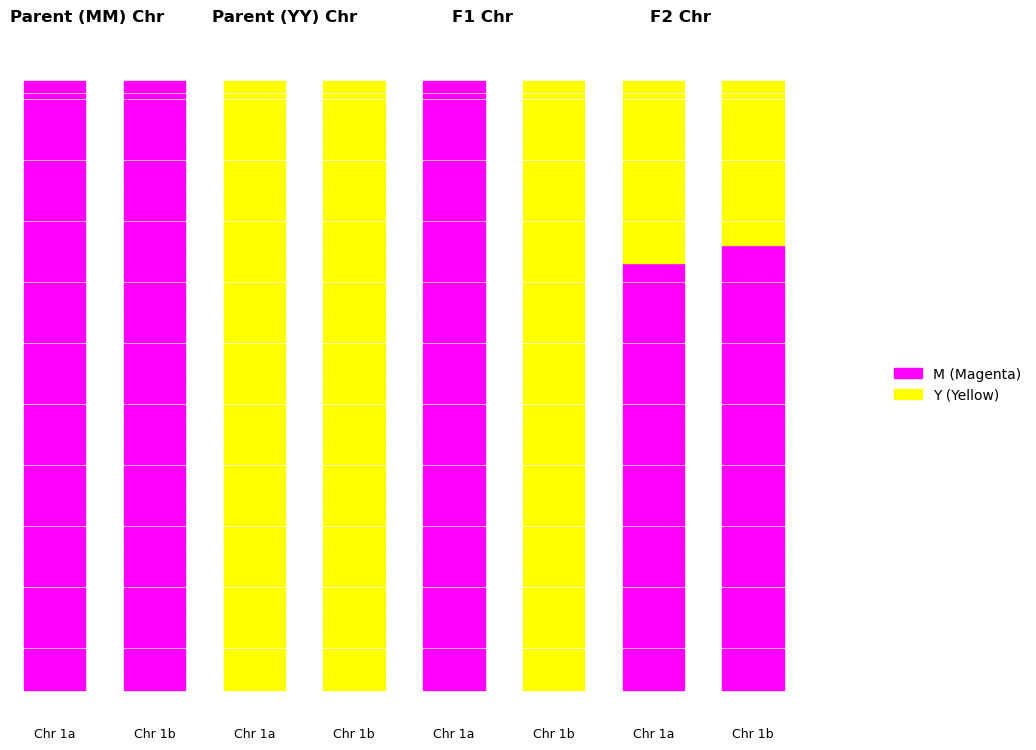

In [10]:
# Visualise Representative Chromosomes Across Generations

print("\n--- Visualising Chromosomes ---")

# 1. Select representative individuals
# For P0, we take the original parents.
representative_p0_A = parent_magenta
representative_p0_B = parent_yellow

# For F1, all individuals are identical, so take the first one.
representative_f1 = f1_population[0]

# For F2, take the first individual generated.
representative_f2 = f2_population[0]

# (Optional) If you were to add an F3 generation later, you'd add:
# representative_f3 = f3_population[0] # Assuming you have an f3_population list.

# 2. Compile lists for the plotting function
individuals_to_plot = [
    representative_p0_A,
    representative_p0_B,
    representative_f1,
    representative_f2
]

titles = [
    "Parent (MM) Chr",
    "Parent (YY) Chr",
    "F1 Chr",
    "F2 Chr"
]

# (Optional) If adding F3:
# individuals_to_plot.append(representative_f3)
# titles.append("F3 Individual")

# Call the plotting function
# We'll plot only the first chromosome pair for each individual for clarity across generations.
# The 'max_chromosomes_to_plot=1' argument ensures we only see one pair, even for F2.
plot_individual_chromosomes(individuals_to_plot, titles, chromosome_length, max_chromosomes_to_plot=1)

### Triangle Plot


--- Plotting Triangle Plot ---


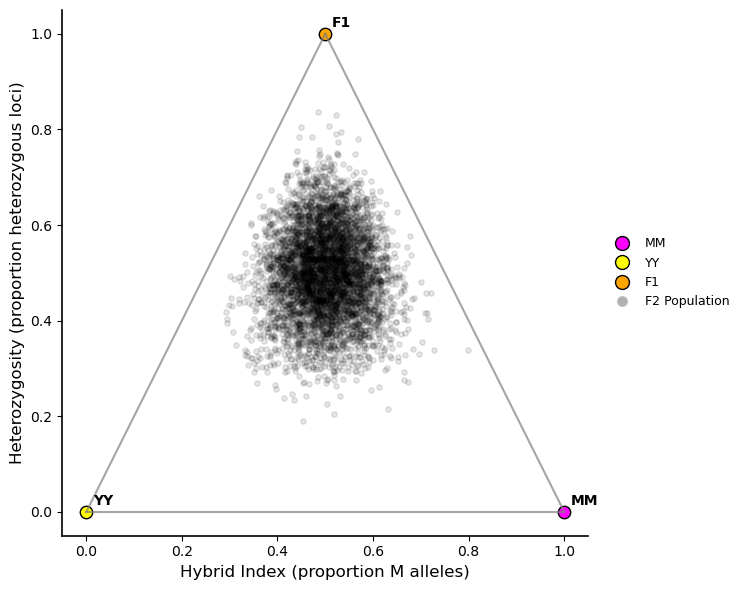

In [11]:
# Triangle Plotting

# This cell is responsible for visualizing the genetic data on a triangle plot (HI vs. He).
# Each point on this plot represents a single individual, showing their overall hybrid status.

print("\n--- Plotting Triangle Plot ---")

# Create a new figure and a set of subplots for the plot.
# figsize=(8, 6) sets the width and height of the plot in inches.
fig, ax = plt.subplots(figsize=(8, 6))

# Customise the plot's appearance by removing the top and right spines (borders)
# for a cleaner look, and setting the line width for the bottom and left spines.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.2)
ax.spines['bottom'].set_linewidth(1.2)

# Set the labels for the X and Y axes, making them descriptive and readable.
ax.set_xlabel("Hybrid Index (proportion M alleles)", fontsize=12)
ax.set_ylabel("Heterozygosity (proportion heterozygous loci)", fontsize=12)

# Plot the F2 individuals as a scatter plot.
# Each point corresponds to one F2 individual's aggregate Hybrid Index and Heterozygosity.
# `alpha=0.1` makes the points semi-transparent, useful for large populations where points overlap.
# `s=15` sets the size of each scatter point.
ax.scatter(
    f2_hybrid_indices,    # X-coordinates: Hybrid Index for each F2 individual.
    f2_heterozygosities, # Y-coordinates: Heterozygosity for each F2 individual.
    color='black',        # Color of the scatter points.
    alpha=0.1,            # Transparency level.
    s=15,                 # Size of the markers.
    label='F2 Population'# Label for this data series, used in the legend.
)

# Plot the parental (P0) and F1 reference points on the same plot.
# These points are typically fixed and represent the extreme ends or the exact middle of the hybridization spectrum.
ax.scatter(p0_A_hi, p0_A_het, color='magenta', s=80, edgecolor='black', label='MM') # Magenta parent
ax.scatter(p0_B_hi, p0_B_het, color='yellow', s=80, edgecolor='black', label='YY') # Yellow parent
ax.scatter(f1_hi, f1_het, color='orange', s=80, edgecolor='black', label='F1') # F1 generation

# Add annotations (text labels) next to the P0 and F1 points for clear identification on the plot.
# `xytext` offsets the text from the point, and `textcoords='offset points'` specifies the offset unit.
ax.annotate('MM', (p0_A_hi, p0_A_het), xytext=(5, 5), textcoords='offset points', fontsize=10, fontweight='bold')
ax.annotate('YY', (p0_B_hi, p0_B_het), xytext=(5, 5), textcoords='offset points', fontsize=10, fontweight='bold')
ax.annotate('F1', (f1_hi, f1_het), xytext=(5, 5), textcoords='offset points', fontsize=10, fontweight='bold')

# Draw the edges of the triangular region that typically encompasses hybrid individuals.
# This visually defines the space where different types of hybrids are expected to fall.
triangle_edges = [
    [(0.0, 0.0), (0.5, 1.0)], # Edge from YY (0,0) to F1 (0.5,1)
    [(0.5, 1.0), (1.0, 0.0)], # Edge from F1 (0.5,1) to MM (1,0)
    [(0.0, 0.0), (1.0, 0.0)]  # Edge from YY (0,0) to MM (1,0) (the x-axis)
]
for (x0, y0), (x1, y1) in triangle_edges:
    ax.plot([x0, x1], [y0, y1], linestyle='-', color='gray', linewidth=1.5, alpha=0.7)

# Set the limits for the X and Y axes. Slightly extend them beyond 0-1 to prevent points from being cut off at the edges.
ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)
# Disable the grid for a cleaner aesthetic, often preferred in these types of plots.
ax.grid(False)
# Ensure the aspect ratio is equal so the triangle appears geometrically correct (not stretched).
ax.set_aspect('equal', adjustable='box')

# Create custom legend elements to clearly label the different populations on the plot.
# Line2D is used to create proxy artists for the legend that mimic the scatter plot markers.
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='magenta', markersize=10, markeredgecolor='black', label='MM'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='yellow', markersize=10, markeredgecolor='black', label='YY'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=10, markeredgecolor='black', label='F1'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='black', alpha=0.3, markersize=8, label='F2 Population'),
]

# Add the legend to the plot.
# `loc="center left"` positions it to the left of the center.
# `bbox_to_anchor=(1.02, 0.5)` places it just outside the main plot area to the right, centered vertically.
# `frameon=False` removes the legend's border.
ax.legend(handles=legend_elements, loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=False, fontsize=9)

# Adjust plot layout to prevent labels/legend from overlapping with the plot area.
plt.tight_layout()
# Further adjust the right margin to accommodate the legend.
plt.subplots_adjust(right=0.8)
# Display the plot.
plt.show()

### Dataframe Check

In [14]:
# --- Create and display the DataFrame ---
print("\n--- Genetic Data DataFrame (First 5 rows) ---")
genetic_df = pd.DataFrame(genetic_data_records)
print(genetic_df.head())
print(f"\nTotal records in DataFrame: {len(genetic_df)}")
print("\n--- Genetic Data DataFrame (Last 5 rows) ---")
print(genetic_df.tail())


--- Genetic Data DataFrame (First 5 rows) ---
  generation  individual_id  diploid_chromosome_id  locus_position genotype
0       P0_A              1                      1               0      M|M
1       P0_A              1                      1               1      M|M
2       P0_A              1                      1               2      M|M
3       P0_A              1                      1               3      M|M
4       P0_A              1                      1               4      M|M

Total records in DataFrame: 5010200

--- Genetic Data DataFrame (Last 5 rows) ---
        generation  individual_id  diploid_chromosome_id  locus_position  \
5010195         F2           5102                     10              95   
5010196         F2           5102                     10              96   
5010197         F2           5102                     10              97   
5010198         F2           5102                     10              98   
5010199         F2           5102 